In [ ]:
## visualize and test MSE.py

In [1]:
# 修改后的 visualize.py
import paddle
import matplotlib.pyplot as plt
import numpy as np
import os
import paddle.nn as nn

# 设置模型中的可调参数
N=100
layerlist=[2,64,64,64,64,64,64,64,4]
w=1
modes=12 # FFT特征保留多少分量
note='tPINN_resNet_FFT_ELU'


In [2]:
output_dir = "./output"
layerlist_str = ", ".join(map(str, layerlist))
foldername = f"{note}_w={w}_layers=[{layerlist_str}]"
paralist=[int(file[11:-9]) for file in os.listdir(os.path.join(output_dir,foldername)) if file.startswith('best_model_')]
flag=False
next=0
if len(paralist)>0:
    next=max(paralist)
    flag=True

if flag:
    parameterfile='best_model_'+str(next)+'.pdparams'
else:
    parameterfile='best_model_0.pdparams'
outfilename="temperature_velocity_field_"+str(next)+'.png' 


class ELU(nn.Layer):
    def forward(self, x):
        mask = 0.5 * (paddle.sign(x) + 1)
        # 限制 exp(x) 的输入范围，避免梯度爆炸
        exp_x = paddle.exp(paddle.clip(x,max=10.0)) - 1
        return mask * x + (1 - mask) * exp_x
class ResNetBlock(nn.Layer):
    def __init__(self, in_features, out_features):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(out_features, out_features)
        self.activation = ELU()
        
    def forward(self, x):
        identity = x
        out = self.activation(self.fc1(x))
        out = self.fc2(out)
        out += identity  # Residual connection
        out = self.activation(out)
        return out

# 定义神经网络结构，用于逼近解uvpt
class tPINN(nn.Layer):
    def __init__(self, layerlist,modes):
        super(tPINN, self).__init__()
        self.input_layer = nn.Linear(layerlist[0]+modes*2, layerlist[1])
        self.res_blocks = nn.LayerList([
            ResNetBlock(layerlist[1], layerlist[1]) for _ in range(len(layerlist) - 3)
        ])
        self.output_layer = nn.Linear(layerlist[1], layerlist[-1])
        
    def forward(self, x, y,modes):
        a=1
        # 计算 x 和 y 坐标的 FFT 特征
        x_fft = paddle.real(paddle.fft.fft(x,modes))
        y_fft = paddle.real(paddle.fft.fft(y,modes))
        
        # 将 x, y 和它们的 FFT 特征堆叠
        xy_fft = paddle.concat([x, y, x_fft, y_fft], axis=1)
        
        # 将堆叠的结果作为输入
        out = self.input_layer(xy_fft)
        for res_block in self.res_blocks:
            out = res_block(out)
        result = self.output_layer(out)

        x = xy_fft[:, 0]
        y = xy_fft[:, 1]
        u = result[:, 0]
        v = result[:, 1]
        p = result[:, 2]
        T = result[:, 3]
        
        u = x * (1 - x) * y * (1 - y) * u
        v = x * (1 - x) * y * (1 - y) * v
        T = 1 - x + paddle.sin(paddle.to_tensor(np.pi) * x) * T
        uvpt = paddle.concat([u.unsqueeze(1), v.unsqueeze(1), p.unsqueeze(1), T.unsqueeze(1)], axis=1)
        return uvpt


pinn_model = tPINN(layerlist=layerlist,modes=modes)
pinn_model.set_state_dict(paddle.load(os.path.join(output_dir,foldername,parameterfile)))
print("模型已加载成功")


def visualize_results(model):
    x = np.linspace(0, 1, N)  # 使用标准化的坐标范围
    y = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, y)
    test_data = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
    

    uvpt = model(paddle.to_tensor(X.flatten()[:, None], dtype='float32'),paddle.to_tensor(Y.flatten()[:, None], dtype='float32'),modes=modes)
    u, v, p, T = uvpt[:, 0:1], uvpt[:, 1:2], uvpt[:, 2:3], uvpt[:, 3:4]
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.contourf(X, Y, T.numpy().reshape(N, N), cmap='jet',levels=20)
    plt.colorbar()
    plt.title('Temperature Field')
    
    plt.subplot(1, 2, 2)
    velocity_magnitude = np.sqrt(u.numpy()**2 + v.numpy()**2)
    plt.contourf(X, Y, velocity_magnitude.reshape(N, N), cmap='cool',levels=20)
    plt.colorbar()
    plt.title('Velocity Magnitude')

    output_path = os.path.join(output_dir,foldername, outfilename)
    plt.savefig(output_path)
    plt.close()
    print(f"温度场和速度场已保存到 {output_path}")



visualize_results(pinn_model)

W1107 10:34:36.232833 20088 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 90.0, Driver API Version: 50724.6, Runtime API Version: 50724.6


模型已加载成功
温度场和速度场已保存到 ./output/tPINN_resNet_FFT_ELU_w=1_layers=[2, 64, 64, 64, 64, 64, 64, 64, 4]/temperature_velocity_field_2.png


In [ ]:
## test MSE

模型已加载成功


W1107 10:35:06.769110 20088 tensor.cc:64] The Tensor(place) constructor is deprecated since version 2.3, and will be removed in version 2.4! Please use `paddle::empty/full` method to create a new Tensor instead. Reason: A legal tensor cannot be constructed only based on the `place`, and datatype, shape, layout, etc. is also required.


u:min error-4.214835e-02,max error 4.214406e-02,MSE 3.636027e-04
v:min error-3.338695e-02,max error 5.532861e-02,MSE 4.159845e-04
T:min error-1.049370e-02,max error 7.529706e-04,MSE 1.836691e-05


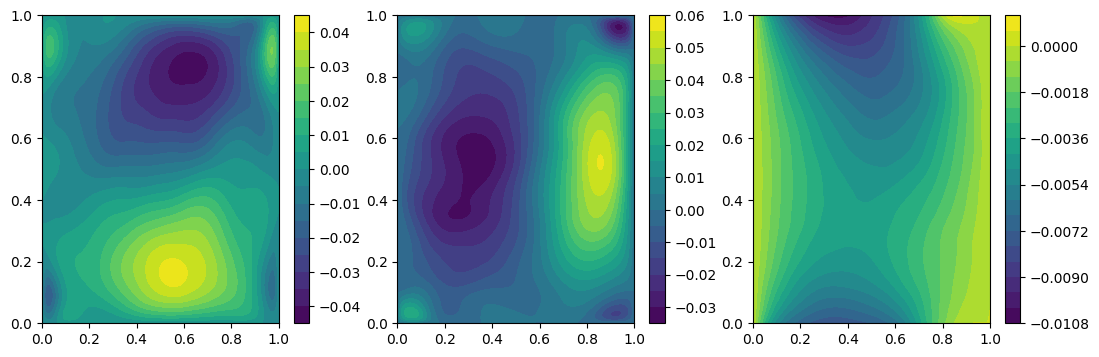

In [3]:
# 修改后的 visualize.py
import paddle
import matplotlib.pyplot as plt
import numpy as np
import os
import paddle.nn as nn
import scipy.io as scio

# 设置模型中的可调参数
N=256



class ELU(nn.Layer):
    def forward(self, x):
        mask = 0.5 * (paddle.sign(x) + 1)
        # 限制 exp(x) 的输入范围，避免梯度爆炸
        exp_x = paddle.exp(paddle.clip(x,max=10.0)) - 1
        return mask * x + (1 - mask) * exp_x
class ResNetBlock(nn.Layer):
    def __init__(self, in_features, out_features):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(out_features, out_features)
        self.activation = ELU()
        
    def forward(self, x):
        identity = x
        out = self.activation(self.fc1(x))
        out = self.fc2(out)
        out += identity  # Residual connection
        out = self.activation(out)
        return out

# 定义神经网络结构，用于逼近解uvpt
class tPINN(nn.Layer):
    def __init__(self, layerlist,modes):
        super(tPINN, self).__init__()
        self.input_layer = nn.Linear(layerlist[0]+modes*2, layerlist[1])
        self.res_blocks = nn.LayerList([
            ResNetBlock(layerlist[1], layerlist[1]) for i in range(len(layerlist) - 3)
        ])
        self.output_layer = nn.Linear(layerlist[1], layerlist[-1])
        
    def forward(self, x, y,modes):
        # 计算 x 和 y 坐标的 FFT 特征
        a=1
        x_fft = paddle.real(paddle.fft.fft(x,modes))
        y_fft = paddle.real(paddle.fft.fft(y,modes))
        
        # 将 x, y 和它们的 FFT 特征堆叠
        xy_fft = paddle.concat([x, y, x_fft, y_fft], axis=1)
        
        # 将堆叠的结果作为输入
        out = self.input_layer(xy_fft)
        for res_block in self.res_blocks:
            out = res_block(out)
        result = self.output_layer(out)

        x = xy_fft[:, 0]
        y = xy_fft[:, 1]
        u = result[:, 0]
        v = result[:, 1]
        p = result[:, 2]
        T = result[:, 3]
        
        u = x * (1 - x) * y * (1 - y) * u
        v = x * (1 - x) * y * (1 - y) * v
        T = 1 - x + paddle.sin(paddle.to_tensor(np.pi) * x) * T
        uvpt = paddle.concat([u.unsqueeze(1), v.unsqueeze(1), p.unsqueeze(1), T.unsqueeze(1)], axis=1)
        return uvpt



# ========================================================================================

# 设置模型中的可调参数
layerlist=[2,64,64,64,64,64,64,64,4]
w=1
modes=12 # FFT特征保留多少分量
note='tPINN_resNet_FFT_ELU'

output_dir = "./output"
layerlist_str = ", ".join(map(str, layerlist))
foldername = f"{note}_w={w}_layers=[{layerlist_str}]"
paralist=[int(file[11:-9]) for file in os.listdir(os.path.join(output_dir,foldername)) if file.startswith('best_model_')]
flag=False
next=0
if len(paralist)>0:
    next=max(paralist)
    flag=True

if flag:
    parameterfile='best_model_'+str(next)+'.pdparams'
else:
    parameterfile='best_model_0.pdparams'
outfilename="error_"+str(next)+'.png' 
# =======================================================================================

mat_data = scio.loadmat('ncc_2D.mat')
exact_uvpt = np.hstack([mat_data['u'].reshape([-1,1]), # 因为数据的矩阵原因需要进行reverse
                        mat_data['v'].reshape([-1,1]),
                        mat_data['T'].reshape([-1,1])])


pinn_model = tPINN(layerlist=layerlist,modes=12)
pinn_model.set_state_dict(paddle.load(os.path.join(output_dir,foldername,parameterfile)))
print("模型已加载成功")

x = np.linspace(0, 1, N)  # 使用标准化的坐标范围
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)
test_data = paddle.to_tensor(np.hstack((X.flatten()[:, None], Y.flatten()[:, None])),dtype='float32')

uvpt = pinn_model(test_data[:,0:1],test_data[:,1:2],modes=12)
u, v, p, T = uvpt[:, 0:1], uvpt[:, 1:2], uvpt[:, 2:3], uvpt[:, 3:4]

fig=plt.figure(figsize=(13,4))
ax=fig.add_subplot(1,3,1)
plt.contourf(X,Y,(u+exact_uvpt[:,0:1]).reshape([N,N]),levels=20)
plt.colorbar()
ax=fig.add_subplot(1,3,2)
plt.contourf(X,Y,(v+exact_uvpt[:,1:2]).reshape([N,N]),levels=20)
plt.colorbar()
ax=fig.add_subplot(1,3,3)
plt.contourf(X,Y,(T-exact_uvpt[:,2:3]).reshape([N,N]),levels=20)
plt.colorbar()
output_path = os.path.join(output_dir,foldername, outfilename)
plt.savefig(output_path)

print(f"u:min error{min(u+exact_uvpt[:,0:1]).numpy()[0]:.6e},max error {max(u+exact_uvpt[:,0:1]).numpy()[0]:.6e},MSE {paddle.mean(((u+exact_uvpt[:,0:1]))**2).numpy():.6e}")
print(f"v:min error{min(v+exact_uvpt[:,1:2]).numpy()[0]:.6e},max error {max(v+exact_uvpt[:,1:2]).numpy()[0]:.6e},MSE {paddle.mean(((v+exact_uvpt[:,1:2]))**2).numpy():.6e}")
print(f"T:min error{min(T-exact_uvpt[:,2:3]).numpy()[0]:.6e},max error {max(T-exact_uvpt[:,2:3]).numpy()[0]:.6e},MSE {paddle.mean(((T-exact_uvpt[:,2:3]))**2).numpy():.6e}")
